In [1]:
import random
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed value
seed_value = 42
set_seed(seed_value)

Using device: cuda


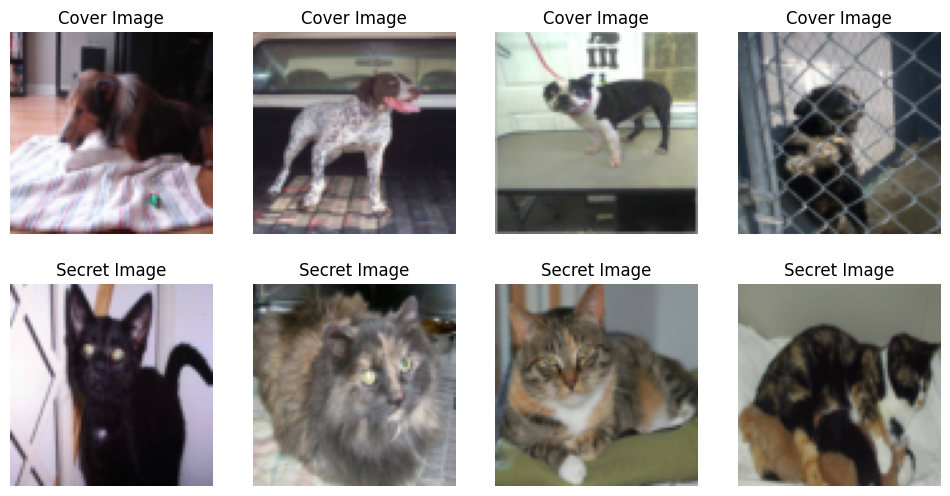

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Directories
training_dir = "training_set/training_set"
dog_dir = os.path.join(training_dir, "dogs")
cat_dir = os.path.join(training_dir, "cats")

testing_dir = "test_set"
dog_dir_test = os.path.join(testing_dir, "dogs")
cat_dir_test = os.path.join(testing_dir, "cats")

# Define a transformation to resize images to the same size and normalize them
image_size = (80,80)  # Ensure the size is a multiple of 16
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

class SteganographyDataset(Dataset):
    def __init__(self, cover_dir, secret_dir, transform=None):
        self.cover_dir = cover_dir
        self.secret_dir = secret_dir
        self.cover_images = os.listdir(cover_dir)
        self.secret_images = os.listdir(secret_dir)
        self.transform = transform

    def __len__(self):
        return min(len(self.cover_images), len(self.secret_images))

    def __getitem__(self, idx):
        cover_image_path = os.path.join(self.cover_dir, self.cover_images[idx])
        secret_image_path = os.path.join(self.secret_dir, self.secret_images[idx])
        
        cover_image = load_and_preprocess_image(cover_image_path)
        secret_image = load_and_preprocess_image(secret_image_path)
        
        return cover_image, secret_image

# Create dataset and dataloader
cover_dir = dog_dir
secret_dir = cat_dir

dataset = SteganographyDataset(cover_dir, secret_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


cover_dir_test = dog_dir_test
secret_dir_test = cat_dir_test

dataset_test = SteganographyDataset(cover_dir_test, secret_dir_test, transform=transform)
dataloader_test = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize the first batch
cover_batch, secret_batch = next(iter(dataloader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(cover_batch[i].permute(1, 2, 0))
    axes[0, i].set_title("Cover Image")
    axes[0, i].axis('off')

    axes[1, i].imshow(secret_batch[i].permute(1, 2, 0))
    axes[1, i].set_title("Secret Image")
    axes[1, i].axis('off')

plt.show()


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncryptionModel(nn.Module):
    def __init__(self):
        super(EncryptionModel, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(in_channels=6, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(in_features=512, out_features=3 * 80 * 80)
    
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(-1, 3, 80, 80)
        return x

class DecryptionModel(nn.Module):
    def __init__(self):
        super(DecryptionModel, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(in_features=512, out_features=3 * 80 * 80)
    
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(-1, 3, 80, 80)
        return x

def custom_loss(cover_image, stego_image, secret_image, extracted_image, alpha=0.75):
    criterion = nn.MSELoss()
    mse_loss_encryption = criterion(stego_image, cover_image)
    mse_loss_decryption = criterion(extracted_image, secret_image)
    return mse_loss_encryption + alpha * mse_loss_decryption


In [19]:
# Create dataset and dataloader
cover_dir = dog_dir
secret_dir = cat_dir
dataset = SteganographyDataset(cover_dir, secret_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


def train_model(encryption_model, decryption_model, dataloader, criterion, optimizer_encryption, optimizer_decryption, device, alpha=0.5, epochs=20):
    encryption_model.train()
    decryption_model.train()
    epoch_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for cover_images, secret_images in dataloader:
            cover_images = cover_images.to(device)
            secret_images = secret_images.to(device)
            
            # Concatenate cover and secret images along the channel dimension
            inputs = torch.cat((cover_images, secret_images), dim=1)
            
            # Forward pass through encryption model
            stego_images = encryption_model(inputs)
            
            # Forward pass through decryption model
            extracted_images = decryption_model(stego_images)
            
            # Compute custom loss
            loss = custom_loss(cover_images, stego_images, secret_images, extracted_images, alpha)
            
            # Backward pass and optimization
            optimizer_encryption.zero_grad()
            optimizer_decryption.zero_grad()
            loss.backward()
            optimizer_encryption.step()
            optimizer_decryption.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}')
        
    return epoch_losses
        
# Initialize models
encryption_model = EncryptionModel().to(device)
decryption_model = DecryptionModel().to(device)

# Define optimizers
optimizer_encryption = torch.optim.Adam(encryption_model.parameters(), lr=1e-3)
optimizer_decryption = torch.optim.Adam(decryption_model.parameters(), lr=1e-3)

# Train the models
epoch_losses = train_model(encryption_model, decryption_model, dataloader, custom_loss, optimizer_encryption, optimizer_decryption, device, alpha=0.75, epochs=20)

d:\Users\haib1\miniconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\haib1\miniconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/20, Loss: 0.1036381561011076
Epoch 2/20, Loss: 0.08132357033714652
Epoch 3/20, Loss: 0.07449294730648398
Epoch 4/20, Loss: 0.06979288378730417
Epoch 5/20, Loss: 0.06678828621283174
Epoch 6/20, Loss: 0.06423101494833827
Epoch 7/20, Loss: 0.06211214102432132
Epoch 8/20, Loss: 0.05828391469269991
Epoch 9/20, Loss: 0.0541250163782388
Epoch 10/20, Loss: 0.052574486780911686
Epoch 11/20, Loss: 0.05204858991317451
Epoch 12/20, Loss: 0.05084380457177758
Epoch 13/20, Loss: 0.04788364051282406
Epoch 14/20, Loss: 0.0461796526517719
Epoch 15/20, Loss: 0.04343984883837402
Epoch 16/20, Loss: 0.04278973749093711
Epoch 17/20, Loss: 0.04157298613153398
Epoch 18/20, Loss: 0.04001565841026604
Epoch 19/20, Loss: 0.03830322215333581
Epoch 20/20, Loss: 0.03674056708067656


In [29]:
ls = train_model(encryption_model, decryption_model, dataloader, custom_loss, optimizer_encryption, optimizer_decryption, device, alpha=0.75, epochs=500)
epoch_losses = epoch_losses.append(l for l in ls)

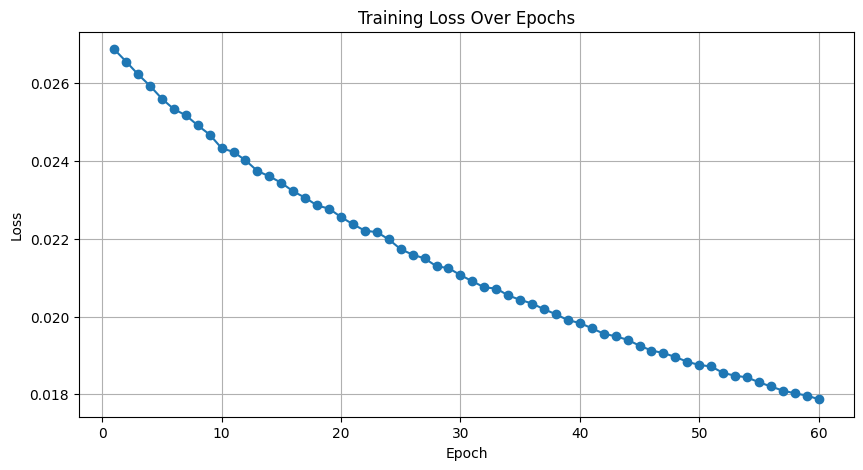

In [26]:
import matplotlib.pyplot as plt

def plot_losses(epoch_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Plot the losses
plot_losses(ls)


In [9]:
def save_losses_to_file(epoch_losses, filename="Resnet_loss.txt"):
    with open(filename, "w") as file:
        for epoch, loss in enumerate(epoch_losses, start=1):
            file.write(f"Epoch {epoch}: Loss = {loss:.4f}\n")

# Example usage
save_losses_to_file(epoch_losses)

In [27]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import cv2  # For PSNR, cv2 is used to convert images to 8-bit

def psnr(img1, img2):
    """Compute PSNR between two images."""
    img1 = img1.numpy().transpose(1, 2, 0) * 255.0  # Convert to [0, 255] range
    img2 = img2.numpy().transpose(1, 2, 0) * 255.0  # Convert to [0, 255] range
    img1 = img1.astype(np.uint8)
    img2 = img2.astype(np.uint8)
    return cv2.PSNR(img1, img2)

def ssim_metric(img1, img2, channel_axis=-1):
    """Compute SSIM between two images."""
    img1 = img1.numpy().transpose(1, 2, 0)  # Convert to HWC format
    img2 = img2.numpy().transpose(1, 2, 0)  # Convert to HWC format
    img1 = np.clip(img1, 0, 1)  # Ensure pixel values are in [0, 1]
    img2 = np.clip(img2, 0, 1)  # Ensure pixel values are in [0, 1]

    # Ensure images have at least 7x7 size
    if img1.shape[0] < 7 or img1.shape[1] < 7:
        return None  # or handle as needed

    # Data range for images normalized to [0, 1]
    data_range = 1.0

    return ssim(img1, img2, multichannel=True, channel_axis=channel_axis, data_range=data_range)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 16.74 dB
PSNR: 20.19 dB
SSIM: 0.5682
SSIM: 0.4871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


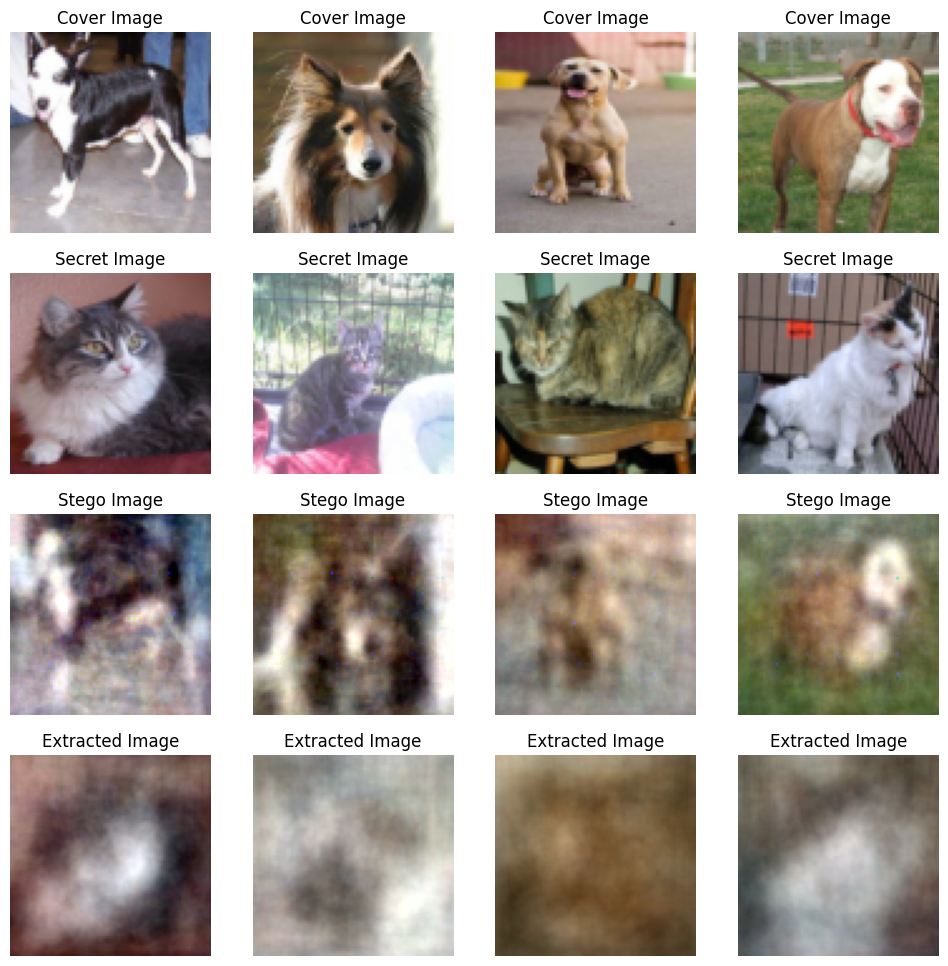

In [28]:
def visualize_sample(hiding_model, extract_model, dataloader, device):
    hiding_model.eval()
    extract_model.eval()
    
    with torch.no_grad():
        for batch in dataloader:
            cover_images, secret_images = batch
            cover_images = cover_images.to(device)
            secret_images = secret_images.to(device)
            
            # Concatenate cover and secret images along the channel dimension
            inputs = torch.cat((cover_images, secret_images), dim=1)
            
            # Forward pass through hiding model to create stego images
            stego_images = hiding_model(inputs)
            
            # Forward pass through extract model to extract secret images
            extracted_images = extract_model(stego_images)
            
            # Move tensors to CPU for visualization
            cover_images = cover_images.cpu()
            secret_images = secret_images.cpu()
            stego_images = stego_images.cpu()
            extracted_images = extracted_images.cpu()
            
            # Compute PSNR and SSIM for the first image in the batch
            psnr_value_container = psnr(cover_images[0], stego_images[0])
            ssim_value_container = ssim_metric(cover_images[0], stego_images[0])
            
            psnr_value_extracted = psnr(secret_images[0], extracted_images[0])
            ssim_value_extracted = ssim_metric(secret_images[0], extracted_images[0])
            
            
            # Print PSNR and SSIM values
            print(f"PSNR: {psnr_value_container:.2f} dB")
            print(f"PSNR: {psnr_value_extracted:.2f} dB")
            if ssim_value_container or ssim_value_extracted  is not None:
                print(f"SSIM: {ssim_value_container:.4f}")
                print(f"SSIM: {ssim_value_extracted:.4f}")
            else:
                print("SSIM: Not computable (image size too small)")
            
            # Visualize the results
            fig, axes = plt.subplots(4, 4, figsize=(12, 12))
            for i in range(4):
                axes[0, i].imshow(cover_images[i].permute(1, 2, 0))
                axes[0, i].set_title("Cover Image")
                axes[0, i].axis('off')

                axes[1, i].imshow(secret_images[i].permute(1, 2, 0))
                axes[1, i].set_title("Secret Image")
                axes[1, i].axis('off')

                axes[2, i].imshow(stego_images[i].permute(1, 2, 0))
                axes[2, i].set_title("Stego Image")
                axes[2, i].axis('off')

                axes[3, i].imshow(extracted_images[i].permute(1, 2, 0))
                axes[3, i].set_title("Extracted Image")
                axes[3, i].axis('off')

            plt.show()
            break

# Visualize a sample from the test dataloader
visualize_sample(encryption_model, decryption_model, dataloader_test, device)


In [8]:
from torchsummary import summary

def test_model(model, input_size, device):
    model.to(device)  # Move model to the device
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Create a dummy input tensor
        dummy_input = torch.randn(1, *input_size).to(device)  # Batch size of 1 and move to device
        # Forward pass
        output = model(dummy_input)
        print("Output shape:", output.shape)

# Initialize models
encryption_model = EncryptionModel()
decryption_model = DecryptionModel()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Encryption Model:")
test_model(encryption_model, (6, 80, 80), device)

# Print model summaries
print("\nEncryption Model Summary:")
summary(encryption_model, (6, 80, 80))

Encryption Model:
Output shape: torch.Size([1, 3, 80, 80])

Encryption Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 40]          18,816
       BatchNorm2d-2           [-1, 64, 40, 40]             128
              ReLU-3           [-1, 64, 40, 40]               0
         MaxPool2d-4           [-1, 64, 20, 20]               0
            Conv2d-5           [-1, 64, 20, 20]          36,864
       BatchNorm2d-6           [-1, 64, 20, 20]             128
              ReLU-7           [-1, 64, 20, 20]               0
            Conv2d-8           [-1, 64, 20, 20]          36,864
       BatchNorm2d-9           [-1, 64, 20, 20]             128
             ReLU-10           [-1, 64, 20, 20]               0
       BasicBlock-11           [-1, 64, 20, 20]               0
           Conv2d-12           [-1, 64, 20, 20]          36,864
      BatchNorm2d